In [1]:
# Импортируем библиотек
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [2]:
# Открываем датафрейм
df = pd.read_csv('kino.csv', sep=';')

# Выводим первые 5 объектов датафрейма
df.head()

,Unnamed: 0,title,year,country,genre,duration,quality,watch,score,rating_kp,rating_imdb,rating_kinogo
0,0,"Анжелика, маркиза ангелов",2013,Франция,Приключения / Мелодрама / Фильмы,113 мин. / 01:53,BluRay,29 227,49,6.2,6.1,4.3
1,1,В центре внимания,2015,США,Криминал / Драма / Биография / Фильмы,129 мин. / 02:09,BDRip 1080p,29 181,58,7.6,8.1,4.5
2,2,Торчки,2001,США,Комедия / Фэнтези / Фильмы,93 мин. / 01:33,BDRip 1080p,29 448,41,6.8,6.2,3.6
3,3,Земля мечтаний,2022,Италия,Новинки / Фильмы / Мюзикл,NaN,WEB-DL,318,2,NaN,NaN,4.5
4,4,Полуночное кафе: Исчезновение невесты,2022,Корея Южная,Новинки / Фильмы / Мелодрама / Фэнтези,103 мин.,WEB-DL,197,2,NaN,NaN,3.5


In [33]:
# Переименуем первый признак
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# Пусть будут все признаки с заглавной буквы
df.columns = [col.title() for col in df.columns]

In [34]:
# Выводим информацию о датафрейме
df.info()
'''Видим пропуски и несоответствия в типах данных'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33806 entries, 0 to 33805
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             33806 non-null  int64  
 1   Title          33802 non-null  object 
 2   Year           33806 non-null  int64  
 3   Country        33805 non-null  object 
 4   Genre          33806 non-null  object 
 5   Duration       33019 non-null  object 
 6   Quality        33806 non-null  object 
 7   Watch          33806 non-null  object 
 8   Score          33806 non-null  int64  
 9   Rating_Kp      23702 non-null  float64
 10  Rating_Imdb    31969 non-null  float64
 11  Rating_Kinogo  33806 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 3.1+ MB


'Видим пропуски и несоответствия в типах данных'

In [35]:
# Количество пропусков
df.isna().sum()

Id                   0
Title                4
Year                 0
Country              1
Genre                0
Duration           787
Quality              0
Watch                0
Score                0
Rating_Kp        10104
Rating_Imdb       1837
Rating_Kinogo        0
dtype: int64

In [36]:
# Удалим строки без названия фильмов и строку с пропуском в "Country"
df.dropna(subset=['Title', 'Country'], axis=0, inplace=True)

In [37]:
# Убирем пробелы из объектов признака и переводим в числовой формат
df['Watch'] = [int(i.replace(' ', '')) for i in df['Watch']]

# Выводим срез признака, первые 3 объекта
df['Watch'][:3]

0    29227
1    29181
2    29448
Name: Watch, dtype: int64

In [38]:
def extract_duration_minutes(duration_string):
    '''Функция преобразовывает строчнй формат признака "Duration" в числовой, 
    выводя продолжительность в минутах и заменяя пропусками ошибочные элементы'''
    
    # Изначальные пропуски, оставляем пропусками
    if duration_string is None:
        return None
    
    # Передаем переменной миуты если они изначально есть и переводим в числовой формат
    try:
        duration_minutes = int(duration_string.split(' мин.')[0])
    except:
        
        # В случае ошибки переводим часы в минуты и передаем переменной в числовом формате
        try:
            time = duration_string.split(' мин. /')[1].split(':')
            duration_minutes = (int(time[0])*60)+(int(time[1]))
            
        # Иные ошибочные объекты заменяем на пропуски    
        except:
            duration_minutes = None
    return duration_minutes

# Применяем функцию к признаку и заменяем исходные значения новыми
df['Duration'] = df['Duration'].apply(lambda x: extract_duration_minutes(x))

df['Duration'][:3]

0    113.0
1    129.0
2     93.0
Name: Duration, dtype: float64

In [39]:
# Создаем списки из строк разделенных ' / ' и обновляем значения
df['Genre'] = df['Genre'].apply(lambda x: x.split(' / '))

df['Genre'][:3]

0        [Приключения, Мелодрама, Фильмы]
1    [Криминал, Драма, Биография, Фильмы]
2             [Комедия,  Фэнтези, Фильмы]
Name: Genre, dtype: object

In [40]:
# Приводим строки к нижнему регистру
df['Quality'] = df['Quality'].str.lower()

# Создаем списки из строк разделенных ' ' и обновляем значения
df['Quality'] = df['Quality'].apply(lambda x: x.split(' '))

df['Quality'][:3]

0          [bluray]
1    [bdrip, 1080p]
2    [bdrip, 1080p]
Name: Quality, dtype: object

In [41]:
def split_country(country):
    '''Функция возвращает список из строки разделенной ', ', в случае ошибки или пропуска возвращает пропуск'''
    
    # Возвращает пропуск, если он там был 
    if country is None:
        return None
    
    # Если нет ошибок, то возвращается список из строки разделенной ', '
    else:
        try:
            return country.split(', ')
        
        # В случае ошибки позвращает пропуск
        except:
            return None
        
# Применяем функцию и обновляем значения
df['Country'] = df['Country'].apply(split_country)

In [42]:
# Удвоим значения признака "Rating_Kinogo", т.к. он оценивает по пятибальной шкале
df['Rating_Kinogo'] = df['Rating_Kinogo']*2

"Видим отсутствие выбросов и корреляцию между рейтингом 'KP' и 'Imdb"

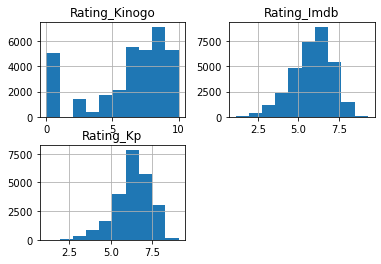

In [43]:
# Выводим гистограммы распределения рейтингов
df[['Rating_Kinogo', 'Rating_Imdb', 'Rating_Kp']].hist()
'''Видим отсутствие выбросов и корреляцию между рейтингом 'KP' и 'Imdb'''

In [44]:
# Заменим пропуски на значение 100, так как 0 входит в шкалу рейтинга 
df['Rating_Imdb'] = df['Rating_Imdb'].fillna(100)
df['Rating_Kp'] = df['Rating_Kp'].fillna(100)

# Функция возвращает в новой колонке среднее значение рейтингов
def mean_rating(rating1, rating2, rating3):
    
    # Передаем переменной список оценок не равных 100
    values = [v for v in [rating1, rating2, rating3] if v != 100]
    
    # Если количество оценок > 1, возвращаем среднее 
    if len(values) > 1:
        avg = sum(values) / len(values)
    # Иначе возвращаем значение рейтинга "Kinogo", т.к. в нем нет пропусков
    else:
        avg = rating3
    return round(avg)

# Применяем функцию и обновляем данные
df['Mean_rating'] = df.apply(
    lambda x: mean_rating(x['Rating_Kp'], x['Rating_Imdb'], x['Rating_Kinogo']), axis=1
)

# Удаляем теперь уже не нужные колонки рейтингов
df = df.drop(['Rating_Kp', 'Rating_Imdb', 'Rating_Kinogo'], axis=1)

In [45]:
# Выводим пропуски
df.isna().sum()

Id                0
Title             0
Year              0
Country           0
Genre             0
Duration       1169
Quality           0
Watch             0
Score             0
Mean_rating       0
dtype: int64

In [46]:
# Заполняем пропущенные значения средним
df = round(df.fillna(df['Duration'].mean()))

In [47]:
def one_hot(data, labels):
    '''Функция выполняет метод One-hot encoder'''
    # Разделяем списки в столбцах на отдельные строки
    for label in labels:
        data = data.explode(label)

    # Применяем get_dummies() к столбцам
    dummies = pd.get_dummies(data[labels], prefix='', prefix_sep='')

    # Удаляем столбцы, которые были закодированы
    data.drop(labels, axis=1, inplace=True)

    # Объединяем исходный DataFrame с новым
    return pd.concat([data, dummies], axis=1)

In [48]:
# Начальное время
start_time = time.time()

# Создаем список из признаков который нужно бинаризировать
labels = ['Genre', 'Quality', 'Country']

# Применяем функцию
df = one_hot(df, labels)

# Конечное время
end_time = time.time()

# Выводим время из разницы конечного времени и стартового
print("Время выполнения: ", end_time - start_time, "секунд")

Время выполнения:  1.4207711219787598 секунд


In [49]:
# Объединяем признаки, которые в результате выполнения бинаризации дублировались
df = df.groupby('Id').agg(max).reset_index()

In [50]:
# Объединеняем колонок и замена 0 на 1, если в одной из колонок есть 1, чтобы уменьшить количество признаков
df['Quality_bad'] = (df['vhs'] | df['vhsrip'] | df['tc'] | df['ts']
                | df['380'] | df['380p'] | df['sat'] | df['180p'] 
                | df['360p'] | df['480p'] | df['camrip'] | df['dvhs'] 
                | df['орт:'])

df['Quality_good'] = (df['hd'] | df['hdrip'] | df['hdrip,'] 
                 |df['tv'] | df['tvrip'] | df['hddvd'] 
                 | df['hddvdrip'] | df['720'] | df['720p'] 
                 | df['hdtv'] | df['hdtvrip'] | df['hdtvrip,'] 
                 | df['hdvt'] | df['dvdrip'] | df['dvdscr'] 
                 | df['dvb'] | df['dvbrip'] | df['iptv'] 
                 | df['iptvrip'] | df['satrip'])

df['Quality_best'] = (df['web-dl'] | df['web-dl,'] | df['web-dlrip'] 
                  | df['webdl'] | df['webdlrip'] | df['webrip'] 
                  | df['bluray'] | df ['2160p'] | df['1080'] 
                  | df['1080p'] | df['bd'] | df['bdremux'] 
                  | df['bdrip'] | df['bdrip,'] | df['fullhd'] 
                  | df['uhd-bdremux'])

df['Unknown'] = df['неизвестно'] | df['-']

In [51]:
# Удаляем лишние признаки
df = df.drop(
    ['1080', '1080p', '380', '380p', '720', 
    '720p','180p', '360p', '480p', '2160p',
    'bd', 'bdremux', 'bdrip', 'bdrip,', 'dvb',
    'dvbrip','dvdrip', 'dvdscr','hddvd', 'hddvdrip', 
    'hd', 'hdrip', 'hdrip,','hdtv', 'hdtvrip',
    'hdtvrip,', 'hdvt', 'iptv', 'iptvrip', 'sat',
    'satrip', 'tc', 'ts', 'tv', 'tvrip',
    'vhs', 'vhsrip', 'web-dl', 'web-dl,', 'web-dlrip',
    'webdl', 'webdlrip', 'webrip', 'bluray', 'неизвестно',
    '-', 'camrip', 'dvhs', 'fullhd', 'uhd-bdremux', 'орт:']
    , axis=1)

In [52]:
# Сокращаем количество признаков объединяя не популярные признаки в один

# Создаем признак с нулями
df['Other_country'] = 0

# Создаем пустой список для дальнейшего удаления лишних признаков
drop_list = []

# В цикле перебираем индексы всех признаков стран
for i in range(40, df.shape[1]-5):
    
    # Передаем переменной имя признака
    columns_name = df.columns[i]
    
    # В условии выбирается признаки, в которых количество не нулевых обектов меньше 330
    if len(df[df[columns_name] != 0]) < 330:
        
        # Обновляем новый признак, объединяя старый с новым заменяя 0 на 1
        df['Other_country'] = df[columns_name] | df['Other_country']
        
        # Добавляем в список для удаления ненужный признак
        drop_list.append(columns_name)

# Удаляем признаки
df = df.drop(drop_list, axis=1)

In [53]:
# То же что и выше для жанров
df['Other_genre'] = 0
drop_list2 = []
for i in range(7, 40):
    columns_name = df.columns[i]
    if len(df[df[columns_name] != 0]) < 330:
        df['Other_genre'] = df[columns_name] | df['Other_genre']
        drop_list2.append(columns_name)
df = df.drop(drop_list2, axis=1)

In [54]:
# Видим, что этот признак есть у каждого объекта
(df['Фильмы'] == 0).sum()

0

In [55]:
# Удаляем бесполезный признак
df = df.drop(['Фильмы'], axis=1)

In [56]:
# Посмотрим, есть ли корреляция между признаками и целевой переменной
plt.figure(figsize=(200, 200))
sns.heatmap(df.corr(method='spearman').round(1), annot=True)

<AxesSubplot:>

In [59]:
# Обновим признак 'Id' значениячи index, т.к. в результате обработки они не совпадают
df['Id'] = df.index

In [60]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,33791,33792,33793,33794,33795,33796,33797,33798,33799,33800
Id,0,1,2,3,4,5,6,7,8,9,...,33791,33792,33793,33794,33795,33796,33797,33798,33799,33800
Title,"Анжелика, маркиза ангелов",В центре внимания,Торчки,Земля мечтаний,Полуночное кафе: Исчезновение невесты,Бо,Злые соседи,Укус,Внутри,Зов предков,...,Хэллоуин у тёти Этель,Бэк Форк,Беседуя об «Ирландце»,Ищейка,Джон Малэйни обед с подростками,Лиам: как всё было,"Тело помнит, когда мир развалился",Месть понтианака,Возвращение Танги,Нарциссы
Year,2013,2015,2001,2022,2022,2022,2022,2022,2023,1996,...,2018,2019,2019,2019,2019,2019,2019,2019,2019,2019
Duration,113.0,129.0,93.0,101.0,103.0,120.0,89.0,99.0,105.0,91.0,...,80.0,98.0,23.0,95.0,70.0,85.0,105.0,92.0,93.0,93.0
Watch,29227,29181,29448,318,197,265,1017,760,8281,31680,...,5034,1808,1520,7311,2083,2957,2007,3624,4009,2845
Score,49,58,41,2,2,0,3,8,27,16,...,19,3,4,16,5,3,6,8,8,4
Mean_rating,7,8,7,9,7,4,7,6,6,8,...,4,6,6,5,6,8,6,6,5,6
Документальные,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
Комедия,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
Семейный,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [61]:
# Вводим переменную для параметра 'random_state', чтобы результат был повторяем
SEED = 42

# Передаем переменной 'X' не целевые признаки, за исключением категориальных
X = df.drop(['Mean_rating', 'Id', 'Title'], axis = 1)

#Передаем переменной 'y' целевой признак
y = df['Mean_rating']

# разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Стандартизируем только X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Масштабируем оба X_train и X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Выводим размер тренинировочной и тестовой выборки
(X_train.shape, X_test.shape)

((27040, 51), (6761, 51))

In [62]:
# Применим метод 'LinearRegression'

# Создаем экземпляр модели линейной регрессии
lr = LinearRegression()

# Обучаем модель на тренировочной выборке
lr.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = lr.predict(X_test)

# Вычисляем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Оценка точности на тестовом наборе данных
accuracy = lr.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

MSE: 2.412267985308103
Accuracy: 25.34%


In [63]:
# Применим метод "Decision Tree"

dtr = DecisionTreeRegressor(random_state=SEED)

# Обучаем модель на тренировочной выборке
dtr.fit(X_train, y_train)

# Делаем предсказания на тестовой выборке
y_pred = dtr.predict(X_test)

# Вычисляем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Оценка точности на тестовом наборе данных
accuracy = dtr.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

MSE: 1.646797810974708
Accuracy: 49.03%


In [64]:
# Используем модель градиентный бустинг

# Инициализация модели и задание гиперпараметров
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=SEED)

# Обучение модели на тренировочных данных
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Вычисляем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Оценка точности на тестовом наборе данных
accuracy = model.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

MSE: 1.0123154374895855
Accuracy: 68.67%


In [65]:
# Применим ансамбль "Bagging"

# Создаем базовую модель решающего дерева
base_model = DecisionTreeRegressor(random_state=SEED)

# Создаем алгоритм Bagging для регрессии на базе модели решающего дерева
bagging_model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=SEED)

# Обучаем модель на обучающей выборке
bagging_model.fit(X_train, y_train)

# Получаем прогнозы на тестовой выборке
y_pred = bagging_model.predict(X_test)

# Вычисляем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Оценка точности на тестовом наборе данных
accuracy = bagging_model.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

MSE: 0.9505842331016122
Accuracy: 70.58%


In [66]:
# Применим ансамбль "Stacking"

# Определяем базовые модели
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=10, random_state=SEED)
gbr = GradientBoostingRegressor(n_estimators=10, random_state=SEED)

# Определяем мета-модель
meta_model = LinearRegression()

# Определяем модель стекинга
stack = StackingCVRegressor(regressors=(lr, rf, gbr),
                            meta_regressor=meta_model,
                            cv=5,
                            shuffle=True,
                            random_state=SEED)

# Обучаем модель стекинга
stack.fit(X_train, y_train)

# Вычисляем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Оценка точности на тестовом наборе данных
accuracy = stack.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

MSE: 0.9505842331016122
Accuracy: 71.38%


In [67]:
# Используем метод поиска наилучших гиперпараметров "RandomizedSearch"

# Определение диапазона значений параметра, которые необходимо проверить
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [5, 10, 15, 20, 25, 30, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Создание модели
rfr = RandomForestRegressor()

# Создание объекта RandomizedSearch с использованием 5-кратной кросс-валидации
random_search = RandomizedSearchCV(estimator=rfr,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Обучение модели с использованием RandomizedSearch
random_search.fit(X_train, y_train)

# Вывод наилучшего значения параметра k и соответствующего значения точности
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
0.7234925593773817


In [68]:
# Используя параметры выше, применим ансамбль "Random Forest"

# Создание и обучение случайного леса из 500 решающих деревьев
rfr = RandomForestRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=1, 
                             max_features='sqrt', max_depth=None,  random_state=SEED)
rfr.fit(X_train, y_train)

# Вычисляем среднеквадратичную ошибку
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

# Оценка точности на тестовом наборе данных
accuracy = rfr.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

MSE: 0.9505842331016122
Accuracy: 73.39%
